In [1]:
%matplotlib nbagg
import time
start_time = time.time()

# Variance of SAXS data

There has been a long discussion about the validity (or not) of pixel splitting regarding the propagation of errors [#520](https://github.com/silx-kit/pyFAI/issues/520) [#882](https://github.com/silx-kit/pyFAI/issues/882) [#883](https://github.com/silx-kit/pyFAI/issues/883).
So we will develop a mathematical model for a SAXS experiment and validate it in the case of a SAXS approximation (i.e. no solid-angle correction, no polarisation effect, and of course small angled $\theta = sin(\theta) = tan(\theta)$)

## System under study

Let's do a numerical experiment, simulating the following experiment:

* Detector: 1024x1024 square pixels of 100µm each, assumed to be poissonian. 
* Geometry: The detector is placed at 1m from the sample, the beam center is in the corner of the detector
* Intensity: the maximum signal on the detector is 10 000 photons per pixel, each pixel having a minimum count of a hundreed.
* Wavelength: 1 Angstrom
* During the first part of the studdy, the solid-angle correction will be discarded, same for solid angle corrections.
* Pixel splitting is disables, for this we use one of the folloging rebinning engines:
  - numpy: the slowest available in pyFAI
  - histogram: implemented in cython
  - nosplit_csr: using a look-up table
  - nosplit_csr_ocl_gpu: which offloads the calculation on the GPU
  We will check they all provide the same numerical result
Now we define some constants for the studdy:

In [2]:
pix = 100e-6
shape = (1024, 1024)
npt = 1000
nimg = 1000
wl = 1e-10
I0 = 1e4
Rg = 1.
kwarg = {"npt":npt, 
         #"method": "nosplit_csr_ocl_gpu", 
         "correctSolidAngle":False, 
         "polarization_factor":None,
         "safe":False}


In [3]:
import numpy
from scipy.stats import chi2 as chi2_dist
from matplotlib.pyplot import subplots
from matplotlib.colors import LogNorm
import pyFAI
print(pyFAI.version)
from pyFAI.detectors import Detector
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.gui import jupyter
detector = Detector(pix, pix)
detector.shape = detector.max_shape = shape
print(detector)

0.16.0-beta0
Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m


In [4]:
ai_init = {"dist":1, 
           "poni1":0., 
           "poni2":0., 
           "rot1" : -0.05,
           "rot2" : +.05,
           "detector":detector, 
           "wavelength":wl}
ai = AzimuthalIntegrator(**ai_init)
print(ai)

Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m
Wavelength= 1.000000e-10m
SampleDetDist= 1.000000e+00m	PONI= 0.000000e+00, 0.000000e+00m	rot1=-0.050000  rot2= 0.050000  rot3= 0.000000 rad
DirectBeamDist= 1002.504mm	Center: x=500.417, y=501.043 pix	Tilt=4.051 deg  tiltPlanRotation= 45.036 deg


<IPython.core.display.Javascript object>


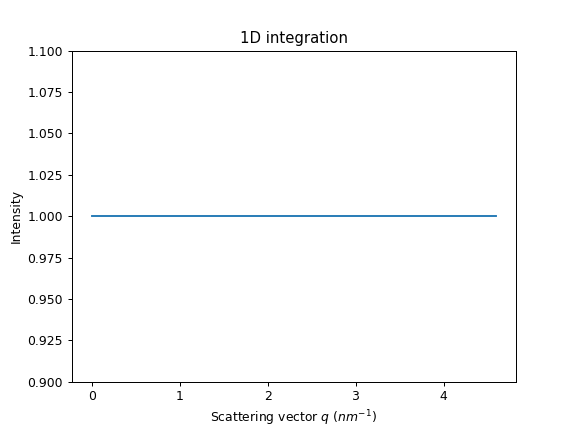

(0.9, 1.1)

In [5]:
# Validation of the flatness of a flat image integrated
flat = numpy.ones(detector.shape)
res_flat = ai.integrate1d(flat, **kwarg)
crv = jupyter.plot1d(res_flat)
crv.axes.set_ylim(0.9,1.1)

In [6]:
#Equivalence of different rebinning engines:

for method in "numpy", "histogram", "nosplit_csr", "nosplit_csr_ocl_gpu":
    ai.reset()
    res_flat = ai.integrate1d(flat, method=method, **kwarg)
    print("timeit for method=", method, "max error:", abs(res_flat.intensity-1).max())
    % timeit res_flat = ai.integrate1d(flat, method=method, **kwarg)

timeit for method= numpy max error: 0.0
39.2 ms ± 64.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
timeit for method= histogram max error: 0.0


21.4 ms ± 2.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
timeit for method= nosplit_csr max error: 0.0


1.51 ms ± 3.53 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
timeit for method= nosplit_csr_ocl_gpu max error: 1.1920929e-07
1.79 ms ± 618 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
# so we chose the nosplit_csr_ocl_gpu, other methods may be faster depending on the computer
kwarg["method"] = "nosplit_csr_ocl_gpu"

<IPython.core.display.Javascript object>


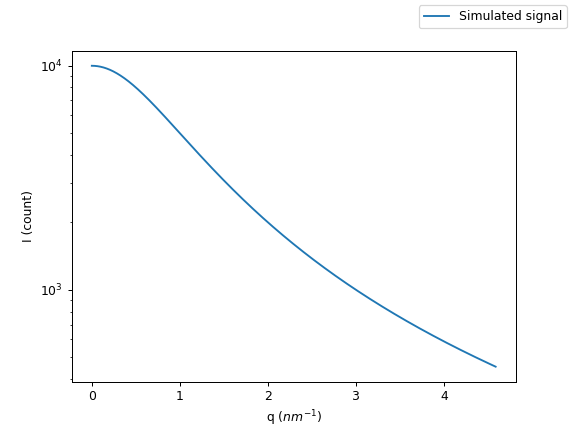

In [8]:
# Generation of a SAXS curve with the shape of a lorentzian curve

q = numpy.linspace(0, res_flat.radial.max(), npt)
I = I0/(1+q**2)
fig, ax = subplots()
ax.semilogy(q, I, label="Simulated signal")
ax.set_xlabel("q ($nm^{-1}$)")
ax.set_ylabel("I (count)")
fig.legend()

<IPython.core.display.Javascript object>


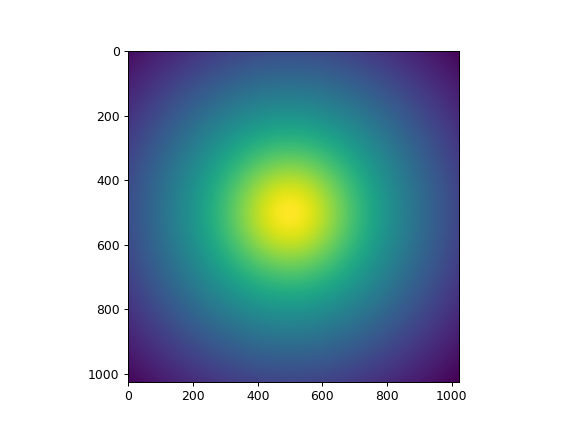

In [9]:
#Reconstruction of diffusion image:

img_theo = ai.calcfrom1d(q, I, dim1_unit="q_nm^-1", 
                         correctSolidAngle=True, 
                         polarization_factor=0.95)
fig, ax = subplots()
ax.imshow(img_theo, norm=LogNorm())


<IPython.core.display.Javascript object>


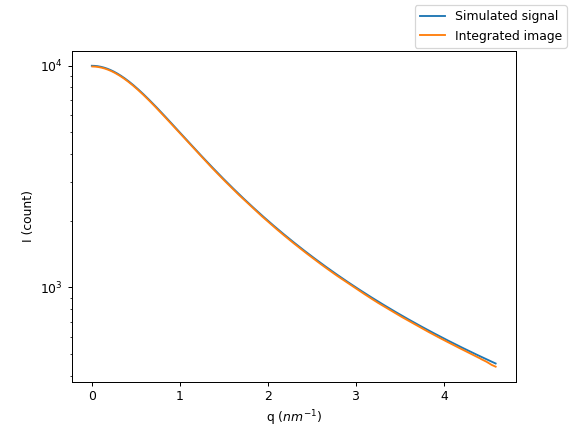

In [10]:
fig, ax = subplots()
ax.semilogy(q, I, label="Simulated signal")
ax.set_xlabel("q ($nm^{-1}$)")
ax.set_ylabel("I (count)")
ax.plot(*ai.integrate1d(img_theo, **kwarg), label="Integrated image")
fig.legend()

In [11]:
%%time

# Now construct the large dataset from poissonian statistics
#this is slow and takes a lot of memory !
if "dataset" not in dir():
    dataset = numpy.random.poisson(img_theo, (nimg,)+img_theo.shape)
# else avoid wasting time
print(dataset.size/(1<<20), "MBytes", dataset.shape)

1000.0 MBytes (1000, 1024, 1024)
CPU times: user 1min 18s, sys: 1.48 s, total: 1min 20s
Wall time: 1min 20s


In [12]:
# are all equivalent ways to calculate the chi2 value for a pair of images using various accelerators...

try:
    from numba import jit
except:
    try: 
        from numexpr import NumExpr
    except:
        def chi2_images(img1, img2):
            """Calculate the Chi2 value for a pair of images with poissonnian noise 
            Numpy implementation"""
            I = img1.ravel()
            J = img2.ravel()
            l = len(I)
            assert len(J) == l
            return ((I-J)**2/(I+J)).sum()/(l-1)
    else:
        expr = ne.NumExpr("((I-J)**2/(I+J))", signature=[("I", numpy.float64),("J", numpy.float64)])
        def chi2_images(img1, img2):
            """Calculate the Chi2 value for a pair of images with poissonnian noise
            NumExpr implementation"""
            return expr(img1, img2).sum()/(img1.size-1)
else:
    @jit
    def chi2_images(img1, img2):
        """Calculate the Chi2 value for a pair of images with poissonnian noise
        Numba implementation"""
        I = img1.ravel()
        J = img2.ravel()
        l = len(I)
        assert len(J) == l
        #version optimized for JIT
        s = 0.0
        for i in range(len(I)):
            a = float(I[i])
            b = float(J[i])
            s+= (a-b)**2/(a+b)
        return s/(l-1)
    
%timeit chi2_images(dataset[0], dataset[1])
%timeit ((dataset[0]- dataset[1])**2/(dataset[0]+dataset[1])).sum()/(dataset[0].size-1)

1.47 ms ± 988 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
7.62 ms ± 5.97 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
img0 = dataset[0]
img1 = dataset[1]

def chi2_images_np(I, J):
    """Calculate the Chi2 value for a pair of images with poissonnian noise 
    Numpy implementation"""
    return ((I-J)**2/(I+J)).sum()/(I.size - 1)
print(chi2_images_np(img0, img1))
%timeit chi2_images_np(img0, img1)

0.9992391020724861
7.59 ms ± 5.87 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
img0 = dataset[0]
img1 = dataset[1]

from numexpr import NumExpr
expr = NumExpr("((I-J)**2/(I+J))", signature=[("I", numpy.float64),("J", numpy.float64)])

def chi2_images_ne(I, J):
    """Calculate the Chi2 value for a pair of images with poissonnian noise
    NumExpr implementation"""
    return expr(I, J).sum()/(I.size-1)

print(chi2_images_ne(img0, img1))
%timeit chi2_images_ne(img0, img1)

0.9992391020724861
1.74 ms ± 48 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
img0 = dataset[0]
img1 = dataset[1]

from numba import jit

@jit
def chi2_images_nu(img1, img2):
    """Calculate the Chi2 value for a pair of images with poissonnian noise
    Numba implementation"""
    I = img1.ravel()
    J = img2.ravel()
    l = len(I)
    assert len(J) == l
    #version optimized for JIT
    s = 0.0
    for i in range(len(I)):
        a = float(I[i])
        b = float(J[i])
        s+= (a-b)**2/(a+b)
    return s/(l-1)

print(chi2_images_nu(img0, img1))
%timeit chi2_images_nu(img0, img1)

0.9992391020725461
1.54 ms ± 1.12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
%%time 
c2i = []
for i in range(nimg):
    res1 = dataset[i]
    for j in range(i):
        c2i.append(chi2_images(res1, dataset[j]))
c2i = numpy.array(c2i)

CPU times: user 13min 17s, sys: 392 ms, total: 13min 17s
Wall time: 13min 17s


<IPython.core.display.Javascript object>


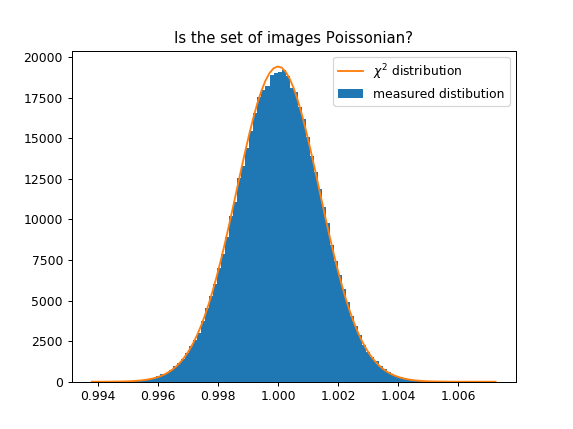

In [17]:
fig, ax = subplots()
h,b,_ = ax.hist(c2i, 100, label="measured distibution")
ax.plot()
size = numpy.prod(shape)
y_sim = chi2_dist.pdf(b*(size-1), size)
y_sim *= h.sum()/y_sim.sum()
ax.plot(b, y_sim, label=r"$\chi^2$ distribution")
ax.set_title("Is the set of images Poissonian?")
ax.legend()

This validates the fact that our set of image is actually a Poissonian distribution around the target image displayed in figure 3.

# Integration of images in the SAXS appoximation:

We can now integrate all images and check wheather all pairs of curves (with their associated error) fit or not the $\chi^2$ distribution 

In [18]:
def chi2_curves(res1, res2):
    """Calculate the Chi2 value for a pair of integrated data"""
    I = res1.intensity
    J = res2.intensity
    l = len(I)
    assert len(J) == l
    sigma_I = res1.sigma
    sigma_J = res2.sigma
    return ((I-J)**2/(sigma_I**2+sigma_J**2)).sum()/(l-1)

In [19]:
%%time
results = []
for i in range(nimg):
    data = dataset[i, :, :]
    results.append(ai.integrate1d(data, variance=data, **kwarg))
#print(results)

CPU times: user 4.23 s, sys: 132 ms, total: 4.36 s
Wall time: 4.35 s


In [20]:
#Check if it is time-critical:
%timeit chi2_curves(results[0], results[1])

10.3 µs ± 37 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [21]:
c2 = []
for i in range(nimg):
    res1 = results[i]
    for j in range(i):
        c2.append(chi2_curves(res1, results[j]))
c2 = numpy.array(c2)

<IPython.core.display.Javascript object>


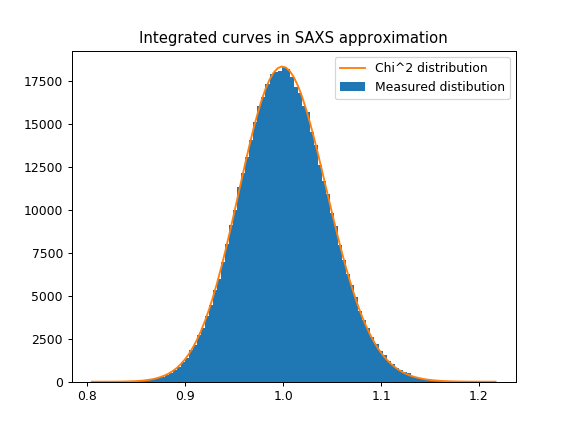

In [22]:
fig, ax = subplots()
h,b,_ = ax.hist(c2, 100, label="Measured distibution")
y_sim = chi2_dist.pdf(b*(nimg-1), nimg)
y_sim *= h.sum()/y_sim.sum()
ax.plot(b, y_sim, label=r"Chi^2 distribution")
ax.set_title("Integrated curves in SAXS approximation")
ax.legend()

In [23]:
low_lim, up_lim = chi2_dist.ppf([0.005, 0.995], nimg) / (nimg - 1)
print(low_lim, up_lim)
print("Expected outliers: ", nimg*(nimg-1)*0.005/2, "got", 
(c2<low_lim).sum(),(c2>up_lim).sum())

0.889452976157626 1.1200681344576493
Expected outliers:  2497.5 got 2362 2989


# And with solid angle correction/polarization correction ?

<IPython.core.display.Javascript object>


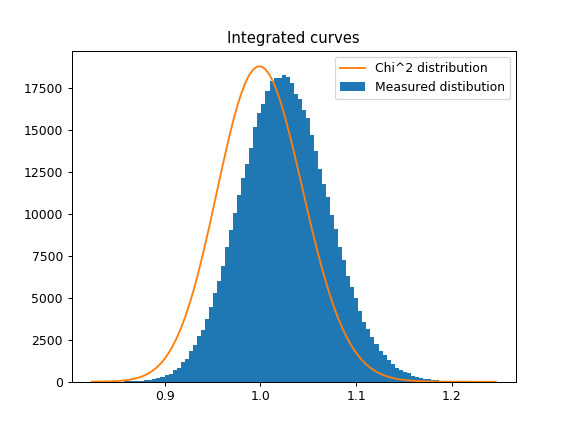

In [24]:
kwarg = {"npt":npt, 
         "method": "nosplit_csr", 
         "correctSolidAngle":True, 
         "polarization_factor":0.95,
         "safe":False}

def plot_distribution(ai, kwargs, nbins=100, legacy=True):
    ai.reset()
    results = []
    c2 = []
    if legacy:
        integrate = ai._integrate1d_legacy
    else:
        integrate = ai._integrate1d_ng
    for i in range(nimg):
        data = dataset[i, :, :]
        r = integrate(data, variance=data, **kwarg)
        results.append(r)    
        for j in range(i):
            c2.append(chi2_curves(r, results[j]))
    c2 = numpy.array(c2)
    fig, ax = subplots()
    h,b,_ = ax.hist(c2, nbins, label="Measured distibution")
    y_sim = chi2_dist.pdf(b*(nimg-1), nimg)
    y_sim *= h.sum()/y_sim.sum()
    ax.plot(b, y_sim, label=r"Chi^2 distribution")
    ax.set_title("Integrated curves")
    ax.legend()
    return fig, ax

f,a = plot_distribution(ai, kwarg)
f.show()


# With next generation azimuthal integrator ...

This does not yet exist in pyFAI but is on the roadmap since begining 2017 ... 
https://github.com/silx-kit/pyFAI/issues/520

We will use an experimental implementation available once PR #913 is merged. 
Unless, here is the idea behind this patch:


In [25]:
# from pyFAI.containers import Integrate1dResult
# from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
# from copy import copy

# class AzimuthalIntegratorNextGen(AzimuthalIntegrator):
#     def integrate1d_ng(self, data, variance, **kwargs):
#         """Demonstrator for the new azimuthal integrator taking care of the normalization, 
#         here implemented only on the solid-angle correction"""
#         kwargs = kwargs.copy()
#         if kwargs["correctSolidAngle"]:
# #             print("do SA")
#             norm = self.solidAngleArray(self.detector.shape).copy()
#         else:
#             norm = numpy.ones(data.shape)
#         kwargs["correctSolidAngle"] = False
#         polf = kwargs.get("polarization_factor")
#         if polf:
# #             print("do Pol")
#             norm *= self.polarization(self.detector.shape, factor=polf)
#         kwargs["polarization_factor"] = None
#         flat = kwargs.get("flat")
#         if flat is not None:
# #             print("do flat")
#             norm *= flat
#         kwargs["flat"] = None
#         denom = self.integrate1d(norm, **kwargs)
#         signal = self.integrate1d(data, **kwargs)
#         sigma2 = self.integrate1d(variance, **kwargs)
# #         print(kwargs)
#         result = Integrate1dResult(denom.radial, 
#                                    signal.sum/denom.sum, 
#                                    numpy.sqrt(sigma2.sum)/denom.sum)
#         result._set_method_called("integrate1d_ng")
#         result._set_compute_engine(denom.compute_engine)
#         result._set_unit(signal.unit)
#         result._set_sum(signal.sum)
#         result._set_count(signal.count)
#         return result
    

# ai2 = AzimuthalIntegratorNextGen(**ai_init)
# kwarg = {"npt":npt, 
#          "method": "nosplit_csr_ocl_gpu", 
#          "correctSolidAngle":True, 
#          "polarization_factor":0.95,
#          "safe":False}

<IPython.core.display.Javascript object>


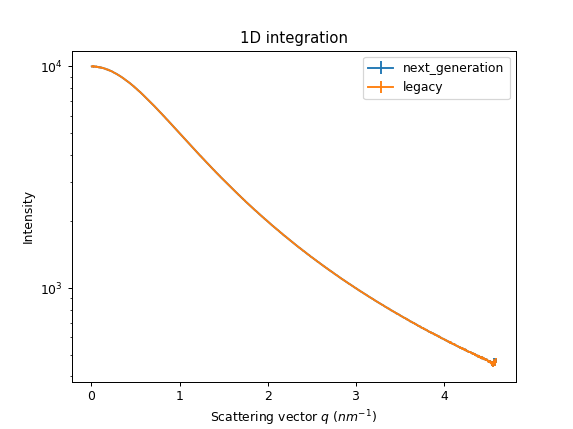

In [26]:
ai.reset()
fig, ax = subplots()
data = dataset[0]
res_ng = ai._integrate1d_ng(data, variance=data, **kwarg)
jupyter.plot1d(res_ng, ax=ax, label="next_generation")
ax.set_yscale("log")
jupyter.plot1d(ai._integrate1d_legacy(data, variance=data, **kwarg), ax=ax, label="legacy")
#jupyter.plot1d(ai._integrate1d_ng(data, variance=data, **kwarg), ax=ax, label="next2")
ax.legend()



<IPython.core.display.Javascript object>


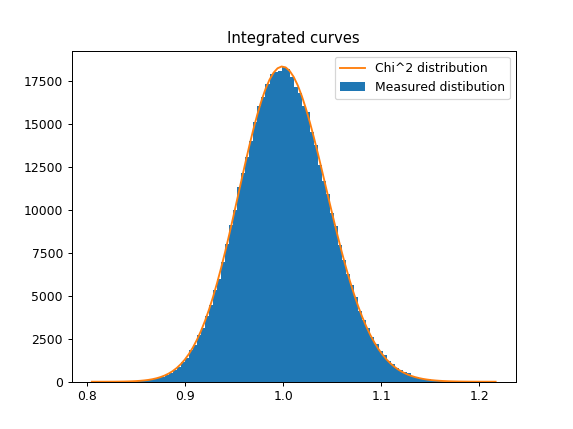

In [27]:
f,a = plot_distribution(ai, kwarg, legacy=False)
f.show()


<IPython.core.display.Javascript object>


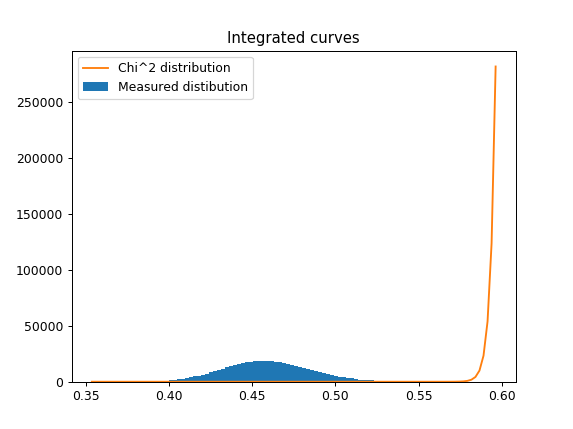

In [28]:
#With pixel-splitting, new integrator:
kwarg["method"] = "csr"
f,a = plot_distribution(ai, kwarg, legacy=False)
f.show()

<IPython.core.display.Javascript object>


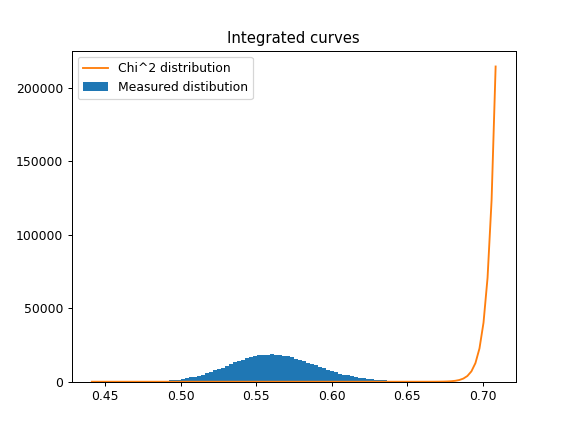

In [29]:
#With fine pixel-splitting, new integrator:
kwarg["method"] = "fullsplit_csr"
f,a = plot_distribution(ai, kwarg, legacy=False)
f.show()

# Conclusion

PyFAI's historical version has been providing the proposing proper error propagation only in the case where any normalization (solid angle, flatfield, polarization, ...) and pixel splitting was disable. This is not the most common use-case for pyFAI I have to confess.

In pyFAI version 0.16, starting with PR #913, there is a way to perform proper error propagation in the case where pixel splitting is disabled, but normalization are all properly performed.

In [30]:
print("Total execution time: ", time.time()-start_time)

Total execution time:  1042.0527215003967
